In [ ]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import datetime
import numpy as np
import gc
!pip install -q keras
import keras
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout
% matplotlib inline
# import regular libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from datetime import datetime
import time
import pymongo
import requests
from pandas.io.json import json_normalize
from statistics import stdev 
import json
import math

# from SciPy packages
from statsmodels.tsa.stattools import adfuller # adfuller test
from statsmodels.graphics.tsaplots import plot_acf # autocorellation plot
from statsmodels.graphics.tsaplots import plot_pacf # partial autocorellation plot

# math function
from math import sqrt

# evaluation metrics
from sklearn.metrics import mean_squared_error

# statistics models
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# libraries to filter warnings in some algorithms
import warnings
warnings.filterwarnings("ignore")

%tensorflow_version 2.x
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline
# import regular libraries 
from datetime import datetime
import time
import pymongo
import requests
from pandas.io.json import json_normalize
from statistics import stdev 
import json

# from SciPy packages
from statsmodels.tsa.stattools import adfuller # adfuller test
from statsmodels.graphics.tsaplots import plot_acf # autocorellation plot
from statsmodels.graphics.tsaplots import plot_pacf # partial autocorellation plot

# math function
from math import sqrt

# evaluation metrics
from sklearn.metrics import mean_squared_error

# statistics models
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# libraries to filter warnings in some algorithms
import warnings
warnings.filterwarnings("ignore")
from scipy import stats

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
myclient = pymongo.MongoClient(host = '139.162.167.213:27017',username="mongo-naascap",password="n44$c4p")
cw = "?api_key=XRSFO6KHEQC87X8UOYZJ"

ts='6h'
market='coinbase-pro'
quote='btc'



def boxAsset(t,c):
    cbp=myclient["Spot"]
    bn=cbp.collection_names()
    l=[word.split("_")[2] for word in bn if(word.startswith(t+"_"+c))]
    l.sort()
    return l

def getAssetClose(t,c,a):
    cbp=myclient["Spot"]
    db=cbp[t+"_"+c+"_"+a]
    db=pd.DataFrame(list(db.find({},{"_id":1,"close":1}).sort("_id",-1)))
    db.rename(columns={'close':a},inplace=True)
    db.index=[(datetime.fromtimestamp(i)) for i in db._id]
    return db[a]


def getMarketCloses(ts):
    assets=boxAsset(ts,market)
    closes=[getAssetClose(ts,market,asset) for asset in assets]
    data = pd.concat(closes,join='outer',axis=1,sort=False)
    date_format = "%d/%m/%Y"
    date = datetime.strptime('01/01/2020', date_format)
    data=data[[date<=dates for dates in data.index]]
    return data


def getColumns(TT):
    df=pd.DataFrame([TT.columns,TT.columns]).T.set_axis(['id', 'name'], axis=1, inplace=False)
    L=[0]*(len(df))
    for i in (range(len(df))):
        L[i]={'id':df["id"][i],'name':df["name"][i]}
    return L
 
def listToDropDown(l):
    df=pd.DataFrame([l,l]).T.set_axis(['Value', 'Label'], axis=1, inplace=False)
    df=df.sort_values("Value").reset_index()
    L=[0]*len(df)
    for i in range(len(df)):
        L[i]={'label':df["Label"][i],'value':df["Value"][i]}
    return L




def TableBaseFromSymbol():
    URL="https://api.cryptowat.ch/pairs"
    res = requests.get(URL + cw)
    T=json_normalize(json.loads(res.content.decode('utf-8'))["result"])
    T=T.loc[:,["symbol","base.symbol","quote.symbol"]]
    return T
T = TableBaseFromSymbol()
def BaseFromSymbol(T,sym):
    if(sym in list(T.symbol)):
        return T["base.symbol"][T.symbol==sym].iloc[0]

def QuoteFromSymbol(T,sym):
    if(sym in list(T.symbol)):
        return T["quote.symbol"][T.symbol==sym].iloc[0]

def getAllAssetCloseByTime(t):
    cbp=myclient["Spot"]
    bn=cbp.collection_names()
    bn=[word for word in bn if(word.split("_")[1]== market and word.split("_")[0]==t)]
    df=pd.DataFrame()
    l2=[]
    l=list(set([word.split("_")[2] for word in bn]))
    TT=list(set([BaseFromSymbol(T,i) for i in l if(QuoteFromSymbol(T,i)) == quote]))
    for asset in TT:
        l1=[word for word in bn if(BaseFromSymbol(T,word.split("_")[2])==asset and QuoteFromSymbol(T,word.split("_")[2]) == quote)]
        rr=[pd.DataFrame(list(cbp[i].find({},{ "_id": 1, "close": 1})),index=pd.DataFrame(list(cbp[i].find({},{ "_id": 1})))._id) for i in l1]
        data = pd.concat([i["close"] for i in rr],join='outer',axis=1,sort=False)
        l2.append(data.mean(axis=1))

    df=pd.concat(l2,axis=1)
    df.columns=(TT)
    df.index=[(datetime.fromtimestamp(i)) for i in df.index]
    df = df.fillna(method = "ffill")
    
    return df

def getAllAssetVolumeByTime(t):
    cbp=myclient["Spot"]
    bn=cbp.collection_names()
    bn=[word for word in bn if(word.split("_")[1]== market and word.split("_")[0]==t)]
    df=pd.DataFrame()
    l2=[]
    l=list(set([word.split("_")[2] for word in bn]))
    TT=list(set([BaseFromSymbol(T,i) for i in l if(QuoteFromSymbol(T,i)) == quote]))
    for asset in TT:
        l1=[word for word in bn if(BaseFromSymbol(T,word.split("_")[2])==asset and QuoteFromSymbol(T,word.split("_")[2]) == quote)]
        rr=[pd.DataFrame(list(cbp[i].find({},{ "_id": 1, "volume_quote": 1})),index=pd.DataFrame(list(cbp[i].find({},{ "_id": 1})))._id) for i in l1]
        data = pd.concat([i["volume_quote"] for i in rr],join='outer',axis=1,sort=False)
        l2.append(data.mean(axis=1))

    df=pd.concat(l2,axis=1)
    df.columns=(TT)
    df.index=[(datetime.fromtimestamp(i)) for i in df.index]
    df = df.fillna(0)
    
    return df


In [ ]:
market='coinbase-pro' #'kraken'
quote='usd' #'btc'
ts='1d' # '5m' '2h' '6h' '12h' '1d'
df=getAllAssetCloseByTime(ts)
df1=getAllAssetVolumeByTime('1d') 

In [ ]:
def get_Close_data(df1,ch):
    df=df1[[ch]]
    x=len(df)%7 
    df=df.drop(df.index[0:x])
    return df

In [ ]:
da= get_Close_data(df1,'btc')

In [ ]:
data=da[da.btc!=0]

In [ ]:
#data.btc=data.btc/255

In [ ]:
# data=data.fillna(data.mean())

In [ ]:
data.head()

,btc
2017-04-28,1359.98
2017-04-29,1380.42
2017-04-30,1369.49
2017-05-01,1391.11
2017-05-02,1465.09


In [ ]:
def create_model_data(data):
  """
  data: pandas data frame
  drop unnecessary columns and revrse in descending order
  return the pandas dataframe
  """
  data = data[['Date'] + [coin + metric for coin in ['BTC_', 'ETH_'] for metric in ['Close', 'Volume']]]
  data = data.sort_values(by='Date')
  return data

In [ ]:
def split_data(data, training_size = 0.8):
  # Returns train and test data set
  return data[:int(training_size * len(data))], data[int(training_size * len(data)):]

In [ ]:
window_len = 30
def create_inputs(data, coins=['btc'], window_length=window_len):
  norm_cols = [coin for coin in coins ]
  inputs = []
  for i in range(len(data) - window_length):
    temp_set = data[i:(i + window_len)].copy()
    inputs.append(temp_set)
    for col in norm_cols:
      inputs[i].loc[:, col] = inputs[i].loc[:, col] / inputs[i].loc[:, col].iloc[0] - 1  
  return inputs

In [ ]:
def create_outputs(data, coin, window_length=window_len):
  return (data[coin][window_len:].values / data[coin][:-window_len].values) - 1

In [ ]:
def to_array(data):
  x = [np.array(data[i]) for i in range(len(data))]
  return np.array(x)

In [ ]:
neurons = 512
activation_function = 'tanh'
loss = 'mse'
optimizer='adam'
dropout = 0.25
batch_size = 128
epochs =53
def build_model(inputs, output_size, neurons, activ_fun=activation_function, dropout=dropout, loss=loss, optimizer=optimizer):
  model = Sequential()
  model.add(LSTM(neurons, return_sequences = True, input_shape=(inputs.shape[1], inputs.shape[2]), activation=activ_fun))
  model.add(Dropout(dropout))
  model.add(LSTM(neurons, return_sequences=True, activation=activ_fun))
  model.add(Dropout(dropout))
  model.add(LSTM(neurons, return_sequences=True, activation=activ_fun))
  model.add(Dropout(dropout))
  model.add(LSTM(neurons, activation=activ_fun))
  model.add(Dropout(dropout))
  model.add(Dense(units=output_size))
  model.add(Activation(activ_fun))
  model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])
  model.summary()
  return model

In [ ]:
def show_plot(data, tag):
  fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]})
  ax1.set_ylabel('Closing Price ($)',fontsize=12)
  ax2.set_ylabel('Volume ($ bn)',fontsize=12)
  ax2.set_yticks([int('%d000000000'%i) for i in range(10)])
  ax2.set_yticklabels(range(10))
  ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
  ax1.set_xticklabels('')
  ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
  ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
  ax1.plot(data['Date'].astype(datetime.datetime),data[tag +'_Open'])
  ax2.bar(data['Date'].astype(datetime.datetime).values, data[tag +'_Volume'].values)
  fig.tight_layout()
  plt.show()
  

def date_labels():
  last_date = market_data.iloc[0, 0]
  date_list = [last_date - datetime.timedelta(days=x) for x in range(len(x_test))]
  return[date.strftime('%m/%d/%Y') for date in date_list][::-1]


def plot_results(history, model, Y_target, coin):
  plt.figure(figsize=(25, 20))
  plt.subplot(311)
  plt.plot(history.epoch, history.history['loss'], )
  plt.plot(history.epoch, history.history['val_loss'])
  plt.xlabel('Number of Epochs')
  plt.ylabel('Loss')
  plt.title(coin + ' Model Loss')
  plt.legend(['Training', 'Test'])

  plt.subplot(312)
  plt.plot(Y_target)
  plt.plot(model.predict(x_train))
  plt.xlabel('Dates')
  plt.ylabel('Price')
  plt.title(coin + ' Single Point Price Prediction on Training Set')
  plt.legend(['Actual','Predicted'])

  ax1 = plt.subplot(313)
  plt.plot(test_set[coin + '_Close'][window_len:].values.tolist())
  plt.plot(((np.transpose(model.predict(x_test)) + 1) * test_set[coin + '_Close'].values[:-window_len])[0])
  plt.xlabel('Dates')
  plt.ylabel('Price')
  plt.title(coin + ' Single Point Price Prediction on Test Set')
  plt.legend(['Actual','Predicted'])
  
  date_list = date_labels()
  ax1.set_xticks([x for x in range(len(date_list))])
  for label in ax1.set_xticklabels([date for date in date_list], rotation='vertical')[::2]:
    label.set_visible(False)

  plt.show()

In [ ]:
# show_plot(data, tag='BTC')

In [ ]:
#model_data = create_model_data(data)
train_set, test_set = split_data(data)
data.head()

,xlm,comp,oxt,algo,xtz,eos,mkr,atom,link,knc,dai,rep,eth,band,etc,bch,btc,xrp,omg,nmr,dash,zrx,ltc
2015-01-27,2.442838e+06,2.398809e+06,2.293358e+06,1.390655e+06,5.429528e+06,1.535803e+06,1.610424e+06,1.305730e+06,1.100688e+07,4.968220e+06,892060.376799,755802.017149,4.520274e+07,2.072400e+06,1.997273e+06,1.417155e+07,1.137102e+08,8.847544e+06,5.959552e+06,1.009167e+06,886879.499943,1.636409e+06,3.034967e+07
2015-01-28,2.442838e+06,2.398809e+06,2.293358e+06,1.390655e+06,5.429528e+06,1.535803e+06,1.610424e+06,1.305730e+06,1.100688e+07,4.968220e+06,892060.376799,755802.017149,4.520274e+07,2.072400e+06,1.997273e+06,1.417155e+07,1.137102e+08,8.847544e+06,5.959552e+06,1.009167e+06,886879.499943,1.636409e+06,3.034967e+07
2015-01-29,2.442838e+06,2.398809e+06,2.293358e+06,1.390655e+06,5.429528e+06,1.535803e+06,1.610424e+06,1.305730e+06,1.100688e+07,4.968220e+06,892060.376799,755802.017149,4.520274e+07,2.072400e+06,1.997273e+06,1.417155e+07,1.137102e+08,8.847544e+06,5.959552e+06,1.009167e+06,886879.499943,1.636409e+06,3.034967e+07
2015-01-30,2.442838e+06,2.398809e+06,2.293358e+06,1.390655e+06,5.429528e+06,1.535803e+06,1.610424e+06,1.305730e+06,1.100688e+07,4.968220e+06,892060.376799,755802.017149,4.520274e+07,2.072400e+06,1.997273e+06,1.417155e+07,1.137102e+08,8.847544e+06,5.959552e+06,1.009167e+06,886879.499943,1.636409e+06,3.034967e+07
2015-01-31,2.442838e+06,2.398809e+06,2.293358e+06,1.390655e+06,5.429528e+06,1.535803e+06,1.610424e+06,1.305730e+06,1.100688e+07,4.968220e+06,892060.376799,755802.017149,4.520274e+07,2.072400e+06,1.997273e+06,1.417155e+07,1.137102e+08,8.847544e+06,5.959552e+06,1.009167e+06,886879.499943,1.636409e+06,3.034967e+07


In [ ]:
x_train = create_inputs(train_set)
y_train_btc = create_outputs(train_set, coin='btc')
x_test = create_inputs(test_set)
y_test_btc = create_outputs(test_set, coin='btc')
x_train, x_test = to_array(x_train), to_array(x_test)


In [ ]:
gc.collect()
np.random.seed(202)
btc_model = build_model(x_train, output_size=1, neurons=neurons)
btc_history = btc_model.fit(x_train, y_train_btc, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_test, y_test_btc), shuffle=False)

In [ ]:
plot_results(btc_history, btc_model, y_train_btc, coin='BTC')

In [ ]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
py.init_notebook_mode(connected=True)
%matplotlib inline

In [ ]:
data.head()

,btc
2017-04-28,1359.98
2017-04-29,1380.42
2017-04-30,1369.49
2017-05-01,1391.11
2017-05-02,1465.09


In [ ]:
btc_trace = go.Scatter(x=data.index, y=data['btc'], name= 'Price')
py.iplot([btc_trace])

In [ ]:
data['btc'].replace(0, np.nan, inplace=True)
data['btc'].fillna(method='ffill', inplace=True)

In [ ]:
btc_trace = go.Scatter(x=data.index, y=data['btc'], name= 'Price')
py.iplot([btc_trace])

In [ ]:
from sklearn.preprocessing import MinMaxScaler
values = data['btc'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [ ]:
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))

741 318


In [ ]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [ ]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

740
317


In [ ]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)

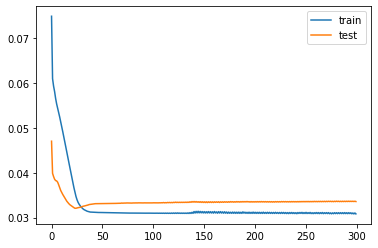

In [ ]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

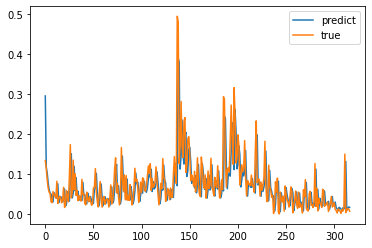

In [ ]:
yhat = model.predict(testX)
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

In [ ]:
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

In [ ]:
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 74127502.786


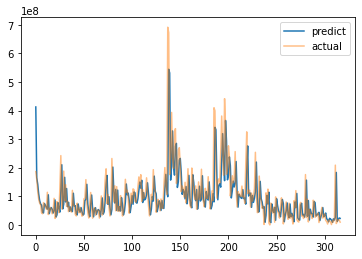

In [ ]:
pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='actual', alpha=0.5)
pyplot.legend()
pyplot.show()

In [ ]:
predictDates = data.tail(len(testX)).index

In [ ]:
testY_reshape = testY_inverse.reshape(len(testY_inverse))
yhat_reshape = yhat_inverse.reshape(len(yhat_inverse))

In [ ]:
actual_chart = go.Scatter(x=predictDates, y=testY_reshape, name= 'Actual Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
py.iplot([actual_chart])